In [11]:
# SETUP

from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import xarray as xr
from sklearn.model_selection import StratifiedShuffleSplit

import shap
import re

sns.set('paper', style='whitegrid')

In [12]:
INPUT_FILENAME = 'connectivity_classifier-SVM_cv-100x4fold'

RESULTS = xr.open_dataset('models/' + INPUT_FILENAME + '.nc5').load()

In [13]:
# prep results

n_subjects = RESULTS['X'].size
X = RESULTS['X'].values
y = RESULTS['y'].values

n_runs = RESULTS['cv_dim'].size
cv_test_size = 8 # TODO RESULTS['cv_test_size'].item()
scoring = 'accuracy' # TODO RESULTS['scoring'].item()

# find split score columns
split_score_cols = [c for c in list(RESULTS.keys()) if re.match(r'split\d+_test_score', c)]

# prep scores
scores = RESULTS[split_score_cols +
                 ['rank_test_score', 'mean_test_score', 'model_name']].to_pandas()
scores['test_score'] = scores[split_score_cols].apply(lambda x: list(x), axis=1)
scores = scores.explode('test_score').reset_index(drop=True)
scores = scores.sort_values('rank_test_score', ascending=False)

# add atlas and kind
scores['atlas'] = scores['model_name'].apply(lambda x: x.split('_')[0])
scores['kind'] = scores['model_name'].apply(lambda x: x.split('_')[1].replace('kind-',''))

# select only relevant columns
scores = scores[['model_name', 'atlas', 'kind', 'test_score', 'mean_test_score']]

# main model scores (ts-agg-network, conn-agg-none)
main_scores = scores.query('model_name.str.contains("tagg-network_cagg-none")')

# simulate chance (dummy classifier)
chance_model = DummyClassifier(strategy='stratified').fit(X, y)
chance_scores = cross_val_score(chance_model, X, y,
                                cv=StratifiedShuffleSplit(n_splits=n_runs, test_size=cv_test_size), 
                                scoring=scoring)

chance_scores = pd.DataFrame(chance_scores, columns=['accuracy'])
# chance_scores['atlas'] = chance_scores['model_name'].apply(lambda x: x.split('_')[0])
# chance_scores['kind'] = chance_scores['model_name'].apply(lambda x: x.split('_')[1].replace('kind-',''))

# sort, mean score and ordering
main_scores = main_scores.sort_values('mean_test_score', ascending=True)
mean_scores = main_scores.groupby('model_name')[['test_score']].mean().reset_index()
order = main_scores['model_name'].drop_duplicates()

# percentage accuracy
main_scores['accuracy_pct'] = main_scores['test_score'] * 100.0
chance_scores['accuracy_pct'] = chance_scores['accuracy'] * 100.0
mean_scores['accuracy_pct'] = mean_scores['test_score'] * 100.0

In [14]:
# Calculate and report 95% confidence intervals

from scipy.stats import bootstrap
import numpy as np

def calculate_ci(scores):
    bootstrap_ci = bootstrap((scores.values,), np.mean, confidence_level=0.95, method='percentile')

    return bootstrap_ci.confidence_interval.low, bootstrap_ci.confidence_interval.high


main_scores.groupby(['atlas','kind'])['accuracy_pct'].apply(calculate_ci)

atlas          kind              
dosenbach2010  correlation             (56.0, 61.875)
               covariance              (50.625, 57.5)
               partialcorrelation    (68.125, 74.125)
               precision                (63.0, 68.75)
               tangent               (67.375, 73.625)
Name: accuracy_pct, dtype: object

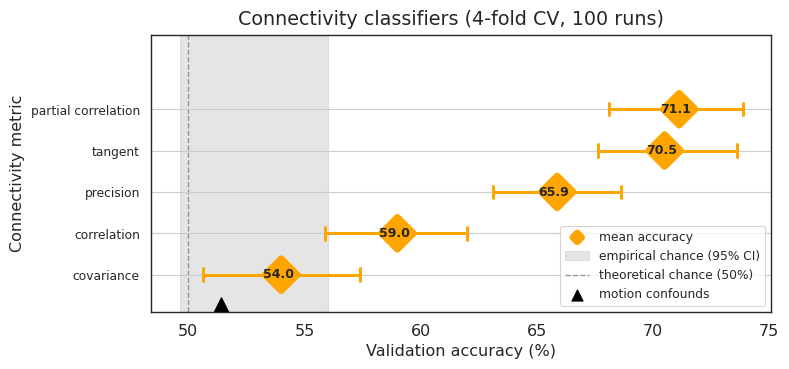

In [15]:
# plot

sns.set('paper', 'white')
_, ax = plt.subplots(figsize=(8, 6 * .6))

# main model scores
g = sns.pointplot(data=main_scores,
              x='accuracy_pct', y='model_name', order=order,
              join=False,
              color='orange',
              markers='D',
              capsize=0.3,
              scale=3,
            #   errorbar=('ci', 95),
              ax=ax,
              label='mean accuracy')

# chance scores
ax.axvspan(*calculate_ci(chance_scores['accuracy_pct']),
           alpha=0.2, color='gray', zorder=-1,
           label='empirical chance (95% CI)')
ax.axvline(x=50, linestyle='--', color='gray',
           linewidth=1, alpha=.8, label='theoretical chance (50%)', zorder=-1)

# annotate the mean points
y_ticklabels = [t.get_text() for t in ax.get_yticklabels()]
for i, model_name, cv_test_score, accuracy_pct in mean_scores.itertuples():
    ticklabel_idx = y_ticklabels.index(model_name)
    ax.annotate(f'{accuracy_pct:.1f}', (accuracy_pct-.8, ticklabel_idx-.08), weight='bold', size=9)

# motion confounds classifier
ax.scatter([51.4], [-.75], marker='^', s=160, color='black', label='motion confounds')

# model names on y-axis ticks
ax.grid(axis='y')
ax.set_yticklabels([l.split('_')[1].replace('kind-','').replace('partial', 'partial ') for l in y_ticklabels])

# axis labels
ax.set_ylim((-.9, len(order)+.8))
ax.set_ylabel('Connectivity metric', fontsize='large')
ax.set_xlabel('Validation accuracy (%)', fontsize='large')
plt.xticks(fontsize='large')

# size of the legend symbols
legends = plt.legend()
legends.legend_handles[0]._sizes = [20]
legends.legend_handles[3]._sizes = [64]

# title
plt.suptitle(f'Connectivity classifiers (4-fold CV, {n_runs} runs)', fontsize='x-large', y=.95)

# save the figure
plt.savefig(f'outputs/figures/{INPUT_FILENAME}.png', bbox_inches='tight')